## Using pipeline model to do the performance and validation of models
## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

## Read data

We have been focusing on a single example...

Realistic examples you may need to deal with highly correlated inputs!

Let's work on an example that has MANY continuous inputs that are CORRELATED and have DIFFERENT scales and magnitudes!

The SONAR example is a BINARY CLASSIFICATION problem with MANY correlated continuous inputs!

In [2]:
cor_df = pd.read_csv( 'ppg_corrosion.csv' )

In [3]:
cor_df.shape

(2000, 79)

In [4]:
cor_df.columns

Index(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30',
       'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40',
       'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50',
       'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60',
       'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70',
       'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'corrosion'],
      dtype='object')

In [5]:
cor_df.columns

Index(['X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30',
       'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40',
       'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50',
       'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60',
       'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70',
       'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'corrosion'],
      dtype='object')

In [6]:
cor_df.dtypes

X01          float64
X02          float64
X03          float64
X04          float64
X05          float64
              ...   
X75          float64
X76          float64
X77          float64
X78          float64
corrosion     object
Length: 79, dtype: object

In [7]:
cor_df.dtypes.value_counts()

float64    75
int64       3
object      1
dtype: int64

In [8]:
cor_df.corrosion.value_counts()

yes    1000
no     1000
Name: corrosion, dtype: int64

In [9]:
cor_df.dtypes

X01          float64
X02          float64
X03          float64
X04          float64
X05          float64
              ...   
X75          float64
X76          float64
X77          float64
X78          float64
corrosion     object
Length: 79, dtype: object

In [10]:
cor_df.corrosion.value_counts()

yes    1000
no     1000
Name: corrosion, dtype: int64

The INPUTS have different magnitudes and scales 

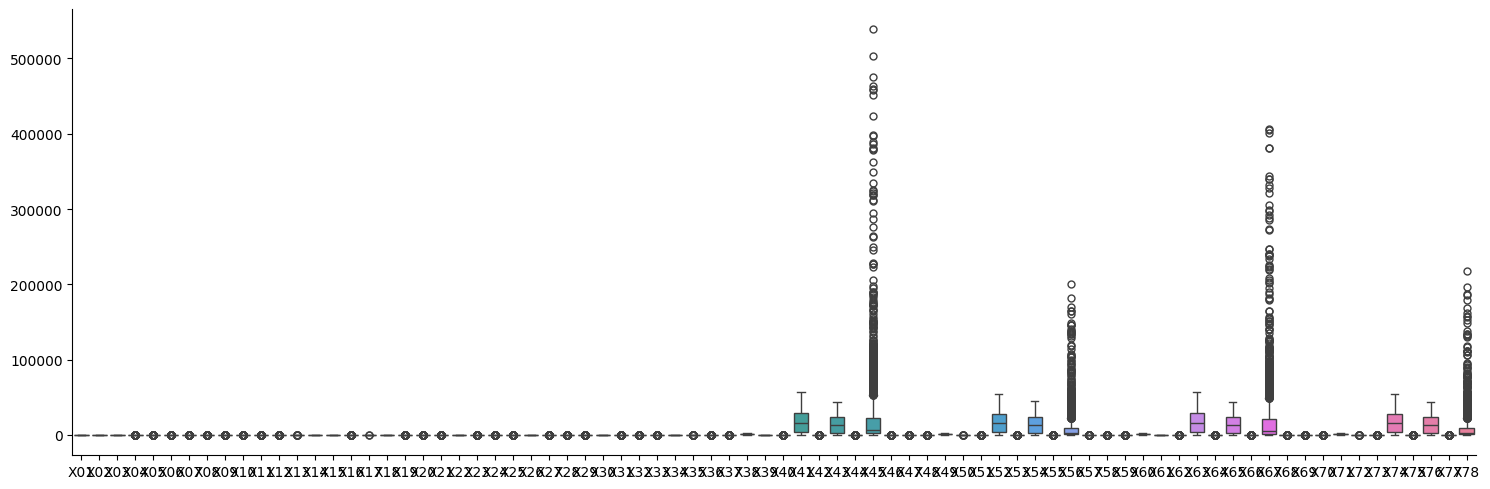

In [11]:
sns.catplot(data = cor_df, kind='box', aspect=3)

plt.show()

The INPUTS are HIGHLY correlated!!!

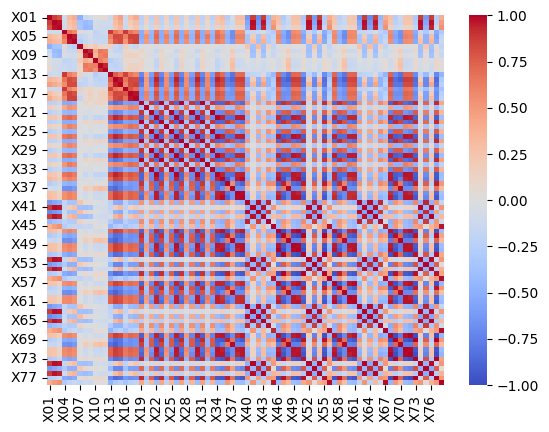

In [13]:
fig, ax = plt.subplots()

sns.heatmap(data = cor_df.corr(numeric_only=True),
            vmin=-1, vmax=1, center=0,
            cmap='coolwarm', 
            ax=ax)

plt.show()

## Elastic Net Penalty

Why would we want to BLEND or MIX the RIDGE and LASSO penalties?

Lasso does NOT know what to do when FEATURES are highly correlated!!!!!

Lasso may struggle in the presence of highly correlated features, but Ridge can manage highly correlated features because Ridge does NOT truly remove any features!

Therefore, if TUNING elastic net produces a RIDGE model that tells you that the FEATURE CORRELATION is impacting things!!!!

However, if we are going to appropriately apply the PENALTY we need the INPUTS to have roughly the SAME scale!!!

We therefore cannot just or use `LogisticRegressionCV()` to tune the elastic net penalty!!!!!

If you need to PREPROCESS the inputs BEFORE fitting the model! You **CANNOT** perform the preprocessing BEFORE splitting the data when you are PREPROCESSING with **data dependent transformations**!!!!!

Data dependant transformations include:

* standardization (centering and scaling)
* PCA

You CAN apply log-transformations, derive polynomials, apply square root functions, or perform any KNOWN function transformation that DOES NOT depend on the data BEFORE splitting!!!

Appropriately applying the PREPROCESSING **WITHIN** the folds is very tedious!!! It is time consuming and error prone to make sure we execute the PREPROCESSING correctly! But don't worry there is a dedicated Module to help you!

## Pipeline

Pipeline MANAGES all actions for PREPROCESSING, TRAINING, Cross-Validation, and TUNING of models!!!!!

In [14]:
from sklearn.pipeline import Pipeline

The Pipeline module lets us specify RECIPES, WORKFLOWS, or Pipelines of actions. These actions are called **STEPS**.

However, before creating the actions, let's SEPARATE out INPUT and OUTPUT.

We will focus on models with LINEAR ADDITIVE FEATURES but we will NOT use `dmatrices()` to create the features. Instead we will manually separate them.

In [15]:
xinputs = cor_df.select_dtypes('number').copy()

In [16]:
youtput = cor_df.loc[:, ['corrosion']].copy()

Convert the DataFrames to NumPy arrays.

In [17]:
X_train = xinputs.to_numpy()

In [18]:
y_train = youtput.corrosion.to_numpy().ravel()

In [19]:
X_train.shape

(2000, 78)

In [20]:
y_train.shape

(2000,)

Our pipeline will consist of 2 steps. The first step will standardize and the second step will fit an ELASTIC NET model.

We therefore need to import the appropriate functions.

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
from sklearn.linear_model import LogisticRegression

Let's initialize the elastic net model before specifying the steps. Our `X_train` array does **NOT** include the BIAS or INTERCEPT column! Therefore, we need the typical or conventional style from scikit-learn which estimates the intercept SEPARATELY from the rest of the COEFFICIENTS.

In [23]:
enet_to_fit = LogisticRegression(penalty='elasticnet', solver='saga', random_state=202, max_iter=25001, fit_intercept=True)

Specify the STEPS of the WORKFLOW or PIPELINE.

In [24]:
enet_wflow = Pipeline(steps=[('std_inputs', StandardScaler()), 
                             ('enet', enet_to_fit)] )

In [25]:
enet_wflow

Pipeline(steps=[('std_inputs', StandardScaler()),
                ('enet',
                 LogisticRegression(max_iter=25001, penalty='elasticnet',
                                    random_state=202, solver='saga'))])

I did NOT specify the TUNING parameters `C` and `l1_ratio` when the elastic net model was intiialized!!!!!

That is because we will ITERATE training and testing the model for many combinations of these two parameters!!!! We will use CROSS-VALIDATION to identify the best combo!

Import the stratified KFold because this is a classification problem.

In [26]:
from sklearn.model_selection import StratifiedKFold

In [27]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

In [28]:
kf.get_n_splits()

5

We will SEARCH over a GRID of candidate tuning parameters and the `GridSearchCV()` function manages that search!

In [29]:
from sklearn.model_selection import GridSearchCV

We need to define the GRID of tuning parameters to use with `GridSearchCV()`. This grid is defined within a dictionary using a VERY SPECIFIC set of syntax!!!

In [30]:
enet_grid = {'enet__C': np.exp( np.linspace(-10, 10, num=17) ),
             'enet__l1_ratio': np.linspace(0, 1, num=3)}

Initialize the GRID SEARCH.

In [31]:
enet_search = GridSearchCV(enet_wflow, param_grid=enet_grid, cv=kf)

RUN THE GRID SEARCH to TUNE the model!

In [32]:
enet_search_results = enet_search.fit( X_train, y_train )

The OPTIMAL or TUNED parameters are provided within an attribute:

In [33]:
enet_search_results.best_params_

{'enet__C': 1.0, 'enet__l1_ratio': 1.0}

Elastic net converted to RIDGE is the indicator that the INPUT correlation is causing problems!!!!!

In [34]:
enet_search_results.best_score_

0.9765

In [35]:
enet_search_results.best_estimator_

Pipeline(steps=[('std_inputs', StandardScaler()),
                ('enet',
                 LogisticRegression(l1_ratio=1.0, max_iter=25001,
                                    penalty='elasticnet', random_state=202,
                                    solver='saga'))])

In [36]:
enet_search_results.best_estimator_.named_steps

{'std_inputs': StandardScaler(),
 'enet': LogisticRegression(l1_ratio=1.0, max_iter=25001, penalty='elasticnet',
                    random_state=202, solver='saga')}

In [37]:
enet_search_results.best_estimator_.named_steps['enet']

LogisticRegression(l1_ratio=1.0, max_iter=25001, penalty='elasticnet',
                   random_state=202, solver='saga')

In [38]:
enet_search_results.best_estimator_.named_steps['enet'].intercept_

array([0.78920252])

In [39]:
enet_search_results.best_estimator_.named_steps['enet'].coef_

array([[-5.56549860e+00,  4.12173985e-02, -1.16297696e+01,
        -4.81151038e-01,  2.16059189e-01,  2.25972219e-01,
         0.00000000e+00, -5.71897657e-01,  0.00000000e+00,
         0.00000000e+00,  2.11619980e-01,  0.00000000e+00,
        -1.58250460e+00, -6.48666810e-01, -2.14685663e-01,
         9.70799908e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -6.73734967e-01,  0.00000000e+00,
         3.32621555e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         7.79950867e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.87489584e-01,  0.00000000e+00,
        -2.68388750e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.04050503e+00,  0.00000000e+00,
         0.00000000e+00,  3.49849005e-01,  1.07358326e+00,
         1.77512667e+00,  0.00000000e+00,  0.00000000e+00,
        -4.02276630e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

BUT, the GRID SEARCH object is a FULL model! Therefore we can DIRECTLY predict with it!

In [40]:
enet_search_results.predict( X_train )[:11]

array(['yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes',
       'no'], dtype=object)

In [41]:
enet_search_results.predict_proba( X_train )[:11, :]

array([[2.22816404e-05, 9.99977718e-01],
       [9.99737949e-01, 2.62050675e-04],
       [9.87398876e-01, 1.26011240e-02],
       [2.23370438e-04, 9.99776630e-01],
       [9.98871818e-01, 1.12818229e-03],
       [4.76019224e-12, 1.00000000e+00],
       [6.81846213e-05, 9.99931815e-01],
       [5.84255734e-01, 4.15744266e-01],
       [6.53373242e-03, 9.93466268e-01],
       [1.31531828e-01, 8.68468172e-01],
       [9.72047403e-01, 2.79525968e-02]])

In [42]:
enet_search_results.classes_

array(['no', 'yes'], dtype=object)

In [43]:
enet_search_results.predict_proba( X_train )[:11, enet_search_results.classes_ == 'M' ].ravel()

array([], dtype=float64)

## PCA as a preprocessing step

Elastic net revealed the input correlation is causing problems!

One way to manage correlation is to REMOVE the correlation via PCA!!!!!!!

PCA can generate NEW uncorrelated features for us!!!!

But...when using CROSS-VALIDATION you **CANNOT** execute PCA and then SPLIT!!!!!

You MUST execute PCA within each FOLD!!!!!

Pipeline will correctly manage the PCA action for you!

Let's use linear additive features from the Principal Components INSTEAD of the original inputs! Therefore, our NEW model will work with UNCORRELATED FEATURES!!!

We can use LASSO rather than worrying about Elastic net!!!!

However, we do NOT know how many Principal Components to use!!!!!!!!

We learned how the VARIANCE or STANDARD DEVIATION of the PCs decreases from the LOWER ORDER PCs to the HIGHER ORDER PCs. But...we do NOT know which PC is associated with the BINARY OUTCOME!!!! We therefore need to treat the NUMBER of PCs to use as a TUNING parameter!

This means you can TUNE PREPROCESSING actions just like you TUNE models!!!!!

First initialize the LASSO model and then define the workflow.

In [44]:
lasso_to_fit = LogisticRegression(penalty='l1', solver='saga', random_state=202, max_iter=25001, fit_intercept=True)

Our new workflow consists of 3 steps. First, STANDARDIZE, second execute PCA, and lastly fit the lasso model.

Import PCA.

In [45]:
from sklearn.decomposition import PCA

In [46]:
pc_lasso_wflow = Pipeline( steps=[('std_inputs', StandardScaler()), 
                                  ('pca', PCA()), 
                                  ('lasso', lasso_to_fit)] )

In [47]:
pc_lasso_wflow

Pipeline(steps=[('std_inputs', StandardScaler()), ('pca', PCA()),
                ('lasso',
                 LogisticRegression(max_iter=25001, penalty='l1',
                                    random_state=202, solver='saga'))])

We now have TUNING parameters coming from 2 different steps, the parameter names reflect the STEP they are associated within the tuning grid!

In [48]:
pc_lasso_grid = {'pca__n_components': [3, 5, 7, 9, 11, 13, 15, 17],
                 'lasso__C': np.exp( np.linspace(-10, 10, num=17) ) }

In [49]:
8 * 17

136

In [50]:
136 * 5

680

In [51]:
pc_lasso_search = GridSearchCV(pc_lasso_wflow, param_grid=pc_lasso_grid, cv=kf)

In [52]:
pc_lasso_search_results = pc_lasso_search.fit( X_train, y_train )

In [53]:
pc_lasso_search_results.best_params_

{'lasso__C': 12.182493960703473, 'pca__n_components': 17}

In [54]:
pc_lasso_search_results.best_score_

0.9480000000000001

In [55]:
pc_lasso_search_results.best_estimator_.named_steps['lasso'].intercept_

array([7.37079132])

In [56]:
pc_lasso_search_results.best_estimator_.named_steps['lasso'].coef_

array([[ 2.36201813, -6.62310777,  6.61294832, -2.54144519,  8.13856578,
         5.50871878, -1.21012106, -0.8093985 , -0.54096353, -0.20332079,
         0.09649769,  1.06455715,  0.08220311, -0.98960419, -0.93465576,
        -1.83630632,  0.14871264]])

## Interact Principal Components

An interaction is a MULTIPLICATION or PRODUCT. What would happen if we INTERACTED ALL PAIRS of the original inputs?

`'(X01 + X02 + X03 + X04 + X05 + X06)**2'`

However, there is a function that can generate ALL MAIN EFFECTS and ALL PAIR WISE PRODUCTS (interactions) for us!

In [57]:
from sklearn.preprocessing import PolynomialFeatures

Has an argument `degree` which specifies the DEGREE of the POLYNOMIAL and it has an argumetn `interaction_only` which specifies if we ARE ONLY creating the MAIN EFFECTS and INTERACTIONS **NOT** raising inputs to polynomial powers!

In [58]:
PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform( X_train ).shape

(2000, 3081)

We therefore CANNOT interact ALL pairs of the original inputs!

But...we could derive a smaller number of features such as through PCA...how many could we interact????

In [59]:
PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit_transform( X_train[:, :20] ).shape

(2000, 210)

We can create ALL PAIR WISE PRODUCTS if we have LESS THAN 19 features!!!!!!

So let's use PCA to generate the uncorrealted FEATURES and then DERIVE the pair wise products FROM the Principal COMPONENTS!!!!

In [60]:
make_pairs = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

Define the Pipeline for the PC, with interaction, and LASSO model!

In [61]:
pc_interact_lasso_wflow = Pipeline( steps=[('std_inputs', StandardScaler() ), 
                                           ('pca', PCA() ), 
                                           ('make_pairs', make_pairs), 
                                           ('lasso', lasso_to_fit )] )

In [62]:
pc_interact_lasso_wflow

Pipeline(steps=[('std_inputs', StandardScaler()), ('pca', PCA()),
                ('make_pairs',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('lasso',
                 LogisticRegression(max_iter=25001, penalty='l1',
                                    random_state=202, solver='saga'))])

Let's use the SAME search grid from before.

In [63]:
pc_interact_lasso_search = GridSearchCV( pc_interact_lasso_wflow, param_grid=pc_lasso_grid, cv=kf )

RUN the grid search!!!

In [64]:
pc_interact_lasso_search_grid = pc_interact_lasso_search.fit( X_train, y_train )

In [65]:
pc_interact_lasso_search_grid.best_params_

{'lasso__C': 42.52108200006278, 'pca__n_components': 17}

In [66]:
pc_interact_lasso_search_grid.best_score_

0.9535

In [67]:
pc_lasso_search_results.best_score_

0.9480000000000001

In [68]:
enet_search_results.best_score_

0.9765

In [69]:
pc_interact_lasso_search_grid.best_estimator_.named_steps['lasso'].coef_

array([[ 2.90806157e-01, -7.47433190e-01,  2.57734805e-01,
         1.41193485e-01,  7.14886937e-02, -1.70491031e-02,
         2.98355574e-01, -8.25831392e-02,  5.31982476e-03,
        -1.46395969e-02,  6.95370156e-02,  1.34777689e-01,
         2.11069720e-02,  2.00884689e-02,  2.18962574e-02,
        -1.44171691e-02, -8.09602779e-02, -9.44217427e-02,
         1.17950078e-01, -2.28052727e-01,  7.53405388e-02,
         1.51214369e-01, -2.83974568e-01,  6.26099268e-02,
         2.53716020e-01,  7.37087939e-03, -2.55204217e-01,
        -1.24219950e-01, -1.32992851e-01,  1.26808410e-02,
        -7.40172286e-02,  9.76636983e-02,  6.23589307e-02,
         2.39913451e-01,  1.37640906e-01,  3.56590879e-01,
        -5.10278601e-02, -9.09237761e-02, -1.05005386e-01,
        -1.14619914e-01,  5.02732274e-02,  5.43484917e-02,
         2.09275246e-01, -9.95559600e-03,  4.88426844e-02,
        -3.08448495e-02,  1.36586325e-01,  2.43513414e-02,
         1.12699840e-01, -4.65790060e-02, -5.14630085e-0

We improved the ACCURACY of a LOGISTIC REGRESSION MODEL by EXECUTING rather complex PREPROCESSING ACTIONS!!!!!